# Extending pulses
This example notebook demonstrates how to remap and extend pulses to different qubits. That is, we can map several ``PulseSequence`` instances to different qubits, thus extending existing pulses defined on different Hilbert spaces, or permute the qubit register a pulse is defined on, without having to define new pulses on the larger Hilbert space.

The functionality is provided by `remap` and `extend`, which, similar to `concatenate`, automatically cache the control matrix and diagonalization attributes for the extended pulse if they are also cached for the mapped pulses. This is only possible for separable bases, that is, bases that can be written as $\mathcal{C}_n = \mathcal{C}_1^{\otimes n}$ with $\mathcal{C}_1$ the basis for a single qubit. Currently, the only implemented basis that fulfills this criterium is the Pauli basis $\mathcal{P}_n = \lbrace\mathbb{1},\sigma_x,\sigma_y,\sigma_z\rbrace^{\otimes n}/d^\frac{n}{2}$.

Concretely, we will define a simple SWAP pulse that will swap the outer two and inner two qubits of a four-qubit register, such as is needed in a QFT.

We start by defining some one- and two-qubit pulses that we would like to map together to form a single pulse on a four-qubit register.

In [1]:
import numpy as np
from qutip.qip import operations

import filter_functions as ff
from filter_functions import util

%matplotlib notebook

In [2]:
I, X, Y, Z = util.paulis

# In order to be able to remap cached filter functions, we need a separable
# basis like the Pauli basis
hadamard_1 = ff.PulseSequence(
    [[X, [np.pi/2/np.sqrt(2)], 'X'],
     [Z, [np.pi/2/np.sqrt(2)], 'Z']],
    [[X, [1], 'X'],
     [Z, [1], 'Z']],
    [1],
    basis=ff.Basis.pauli(1)
)

cphase_12 = ff.PulseSequence(
    [[util.tensor(Z, Z), [np.pi/4], 'ZZ'],
     [util.tensor(Z, I), [-np.pi/4], 'ZI'],
     [util.tensor(I, Z), [-np.pi/4], 'IZ']],
    [[util.tensor(X, I), [1], 'XI'],
     [util.tensor(Z, I), [1], 'ZI'],
     [util.tensor(I, X), [1], 'IX'],
     [util.tensor(I, Z), [1], 'IZ']],
    [1],
    basis=ff.Basis.pauli(2)
)

We now have all the atomic pulses that are required for a SWAP gate. In order to do as little computational work as possible, we cache the filter functions of those pulses now so that we do not need to explicitly calculate them again for the SWAP pulse.

In [3]:
omega = np.geomspace(1/20, 20, 1001)
hadamard_1.cache_filter_function(omega)
cphase_12.cache_filter_function(omega)

Now in order to build the SWAP gate we first have to extend the Hadamard pulse to two qubits in order to transform the controlled-Z gate to a controlled-X gate. As mentioned above, this can be achieved using ``extend``. The function's only positional argument is a mapping of ``PulseSequence``s to qubits in a list of lists format similar to the Hamiltonian format required by the ``PulseSequence`` constructor. In this case, we want to map the Hadamard pulse to the second qubit (indexed by `1`). By default, operator identifiers are mapped by appending the qubit index to the identifier. We can also supply a custom mapping as a third element of each tuple, ``(pulse, qubit, mapping)``.

Moreover, we want to keep track of the same noise operators on the first qubit as we do for `cphase_12`, i.e. $\sigma_x\otimes\mathbb{1}$ and $\sigma_z\otimes\mathbb{1}$ and thus pass those to the function as an additional noise Hamiltonian (by default, only the original single-qubit noise operators would be extended to the second qubit, that is, $\mathbb{1}\otimes\sigma_x$ and $\mathbb{1}\otimes\sigma_z$).

In [4]:
hadamard_2 = ff.extend(
    [(hadamard_1, 1, dict(X='IX', Z='IZ'))],
    additional_noise_Hamiltonian=[[util.tensor(X, I), [1], 'XI'],
                                  [util.tensor(Z, I), [1], 'ZI']]
)

Since ``hadamard`` has cached filter functions, they are also automatically cached for the extended pulse,

In [5]:
print(hadamard_2.is_cached('filter function'))

True


and the extended pulse has the following control and noise operators:

In [6]:
print(hadamard_2.c_oper_identifiers)
print(hadamard_2.n_oper_identifiers)

['IX' 'IZ']
['IX' 'IZ' 'XI' 'ZI']


We can now sandwich the CZ pulse between two Hadamards to transform it to a CNOT and assert the pulse does what it is supposed to by checking the total propagator:

In [7]:
cnot_12 = hadamard_2 @ cphase_12 @ hadamard_2
util.oper_equiv(cnot_12.total_propagator, operations.cnot(control=0, target=1))

(True, 2.356194490192345)

The SWAP gates that we want to implement can be compiled from three CNOTs like follows:

$$
\text{SWAP}(1, 2) = \text{CNOT}(1, 2)\circ\text{CNOT}(2, 1)\circ\text{CNOT}(1, 2)
$$

Thus, we need to reverse the qubits that `cnot_12` is defined on. For this, we use `remap`, which takes a `PulseSequence` instance and a permutation as arguments. Again, we can optionally supply an identifier mapping. In our case, since we only want to reverse the order of the qubits, we map the first to the second and the second to the last qubit and again check the total propagator:

In [8]:
mapping = {}
# We just reverse the order of the qubits, so just reverse the identifiers
mapping.update({i: i[::-1] for i in cnot_12.c_oper_identifiers})
mapping.update({i: i[::-1] for i in cnot_12.n_oper_identifiers})

cnot_21 = ff.remap(cnot_12, (1, 0), oper_identifier_mapping=mapping)

util.oper_equiv(cnot_21.total_propagator, operations.cnot(control=1, target=0))
print(cnot_21.c_oper_identifiers, cnot_21.n_oper_identifiers, sep='\t')

['IZ' 'XI' 'ZI' 'ZZ']	['IX' 'IZ' 'XI' 'ZI']


Finally, we can define the SWAP gate and use `extend` to get the pulse that swaps the first two and last two qubits on a four-qubit register.

In [9]:
swap_12 = ff.concatenate((cnot_12, cnot_21, cnot_12))
all_identifiers = (cnot_21.c_oper_identifiers.tolist() +
                   cnot_21.n_oper_identifiers.tolist())

swap_14_23 = ff.extend(
    [(swap_12, (0, 3), {i: i[0] + 'II' + i[1] for i in all_identifiers}),
     (swap_12, (1, 2), {i: 'I' + i + 'I' for i in all_identifiers})]
)
print(swap_14_23.c_oper_identifiers, swap_14_23.n_oper_identifiers, sep='\n')

['IIIX' 'IIIZ' 'IIXI' 'IIZI' 'IXII' 'IZII' 'IZZI' 'XIII' 'ZIII' 'ZIIZ']
['IIIX' 'IIIZ' 'IIXI' 'IIZI' 'IXII' 'IZII' 'XIII' 'ZIII']


As before, the filter function is already cached:

True


<IPython.core.display.Javascript object>


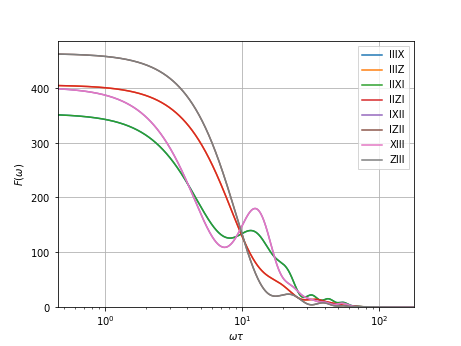

In [10]:
from filter_functions import plotting

print(swap_14_23.is_cached('filter function'))
_ = plotting.plot_filter_function(swap_14_23)